In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

from datetime import datetime
from scipy import stats

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from mlxtend.feature_selection import ColumnSelector
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler, Normalizer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

### 优惠券特征的提取

+ 用户历史领取该优惠券次数
+ 用户历史核销该优惠券次数
+ 用户历史核销该优惠券核销率

In [29]:
base_features_df = pd.read_csv('../features/lcm_base_features.csv')
user_features_df = pd.read_csv('../features/lcm_user_features.csv')

In [30]:
base_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754884 entries, 0 to 1754883
Data columns (total 16 columns):
User_id              int64
Merchant_id          float64
Coupon_id            float64
Distance             float64
Date_received        float64
Is_in_day_consume    float64
Discount             float64
Base_consume         float64
Discount_money       float64
Day_in_month         float64
Day_in_week          float64
Month_in_year        float64
Coupon_type          float64
Offline_consume      float64
Duration             float64
Is_used_coupon       float64
dtypes: float64(15), int64(1)
memory usage: 214.2 MB


In [31]:
def is_debug_df(df, date=20160501, debug=True):
    if debug:
        return df[df['Date_received']<date]
    else:
        return df.copy()
    
df = is_debug_df(base_features_df, debug=True)
df = df[df['Coupon_id'] > 0]

In [32]:
def join(df, col, series, key):
    return multi_join(df, col, series, [key])

def multi_join(df, col, series, keys):
    t = series.to_frame()
    t.columns = [col]
    
    return pd.merge(df, t, on=keys, how='left')

In [33]:
def receive_count(df, target, groupby, is_dup=True):
    if is_dup:
        return df[df['Date_received']>0][target].drop_duplicates().groupby(groupby).size()
    else:
        return df[df['Date_received']>0][target].groupby(groupby).size()

def cousume_count(df, target, groupby, is_dup=True):
    if is_dup:
        return df[df['Offline_consume']>0][target].drop_duplicates().groupby(groupby).size()
    else:
        return df[df['Offline_consume']>0][target].groupby(groupby).size()

def used_count(df, target, groupby, is_dup=True):
    if is_dup:
        return df[df['Is_in_day_consume']>0][target].drop_duplicates().groupby(groupby).size()
    else:
        return df[df['Is_in_day_consume']>0][target].groupby(groupby).size()

def cal_user_used_coupon_rate(row):
    return row.User_used_count/row.User_receive_count

def cal_user_not_used_conpon_count(row):
    return row.User_receive_count - row.User_used_count

def extract_info(df, target, type, groupby, column_name, is_dup=True):
    factory = {
        'receive_type': receive_count,
        'used_type': used_count
    }
    
    target_df = df[groupby].drop_duplicates()
    series = factory[type](df, target, groupby, is_dup)
    
    tdf = multi_join(target_df, column_name, series, groupby)
    tdf = tdf.fillna(0)
    
#     mean = tdf[column_name].mean()
#     tdf[column_name+'_occ'] = tdf[column_name] / mean
    return tdf[groupby + [column_name, ]]

In [34]:
class GroupbyExtractor(TransformerMixin):
    def __init__(self, fn, target, type, groupby, column_name):
        self.fn = fn
        self.target = target
        self.type = type
        self.groupby = groupby
        self.column_name = column_name
    
    def fit(self, *args, **kwargs):
        return self

    def transform(self, X, **transform_params):
        return self.fn(X, self.target, self.type, self.groupby, self.column_name)

In [35]:
keys = ['User_id', 'Coupon_id']
user_coupon_features_df = df[keys].drop_duplicates()
user_coupon_features_df = pd.merge(user_coupon_features_df, user_features_df, on=['User_id'], how='left')

user_coupon_features_df = pd.merge(user_coupon_features_df, extract_info(df, keys, 'receive_type', keys, 'User_coupon_receive_count', False), on=keys, how='left')
user_coupon_features_df = pd.merge(user_coupon_features_df, extract_info(df, keys, 'used_type', keys, 'User_coupon_used_count', False), on=keys, how='left')

user_coupon_features_df['User_coupon_used_rate'] = user_coupon_features_df['User_coupon_used_count'] / user_coupon_features_df['User_coupon_receive_count']

user_coupon_features_df = user_coupon_features_df.fillna(0)
# user_coupon_features_df['User_coupon_used_rate_occ'] = user_coupon_features_df['User_coupon_used_rate'] / user_coupon_features_df['User_coupon_used_rate'].mean()

In [36]:
user_columns = user_features_df.columns.values
user_columns = user_columns[np.where(user_columns !='User_id')] 

user_coupon_features_df = user_coupon_features_df.drop(user_columns, axis=1)

In [37]:
user_coupon_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 680806 entries, 0 to 680805
Data columns (total 5 columns):
User_id                      680806 non-null int64
Coupon_id                    680806 non-null float64
User_coupon_receive_count    680806 non-null int64
User_coupon_used_count       680806 non-null float64
User_coupon_used_rate        680806 non-null float64
dtypes: float64(3), int64(2)
memory usage: 31.2 MB


In [38]:
user_coupon_features_df.columns.values

array(['User_id', 'Coupon_id', 'User_coupon_receive_count',
       'User_coupon_used_count', 'User_coupon_used_rate'], dtype=object)

In [39]:
user_coupon_features_df.to_csv('../features/lcm_user_coupon_features.csv', index=False, header=True)

## 数据分析

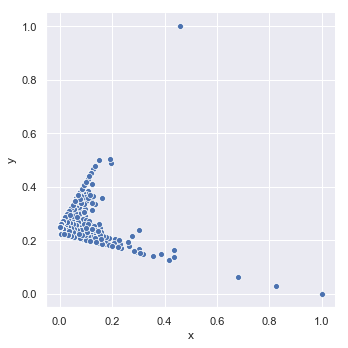

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

tdf = pd.read_csv('../features/lcm_user_coupon_features.csv')
tdf = tdf.drop(['User_id', 'Coupon_id'], axis=1)

ipipe = Pipeline([
    ('pca', PCA(n_components=2)),
    ('scale', MinMaxScaler()),
])

ipipe.fit(tdf)
output = ipipe.transform(tdf)
output_df = pd.DataFrame(data=output, columns=['x', 'y'])

sns.relplot(x="x", y="y", data=output_df);